In [120]:
#Importing packages
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import graphviz
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.model_selection import train_test_split
from hyperopt import hp
import inspect
from hgboost_mod import hgboost
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


## Data cleaning

In [121]:
#Importing the cleaned data
data = pd.read_csv("full_df.csv")

print(data)

#Moving "id" to the first column, so diabetes (the target column) is the last
data = data[ ['id'] + [ col for col in data.columns if col != 'id' ] ]

#Deleting the unnamed column (just a duplicate of id)
#First rename the column
data.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)

# Then, drop the column as usual.
data.drop(["a"], axis=1, inplace=True)

#Inspecting that all looks good.
data

       Unnamed: 0  gender   age  hypertension  heart_disease  smoking_history  \
0               1       0  80.0             0              1                0   
1               2       0  54.0             0              0                5   
2               3       1  28.0             0              0                0   
3               4       0  36.0             0              0                1   
4               5       1  76.0             1              1                1   
...           ...     ...   ...           ...            ...              ...   
99977       99978       0  80.0             0              0                5   
99978       99979       0   2.0             0              0                5   
99979       99980       1  66.0             0              0                3   
99980       99981       0  24.0             0              0                0   
99981       99982       0  57.0             0              0                1   

         bmi  HbA1c_level  

,id,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,80.0,0,1,0,25.19,6.6,140,0
1,2,0,54.0,0,0,5,27.32,6.6,80,0
2,3,1,28.0,0,0,0,27.32,5.7,158,0
3,4,0,36.0,0,0,1,23.45,5.0,155,0
4,5,1,76.0,1,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...,...
99977,99978,0,80.0,0,0,5,27.32,6.2,90,0
99978,99979,0,2.0,0,0,5,17.37,6.5,100,0
99979,99980,1,66.0,0,0,3,27.83,5.7,155,0
99980,99981,0,24.0,0,0,0,35.42,4.0,100,0


In [122]:
#Splitting data into predictor variables and target variable
X = data.iloc[:,1:-1].values
y = data.iloc[:,-1].values

print(X)
y

[[  0.    80.     0.   ...  25.19   6.6  140.  ]
 [  0.    54.     0.   ...  27.32   6.6   80.  ]
 [  1.    28.     0.   ...  27.32   5.7  158.  ]
 ...
 [  1.    66.     0.   ...  27.83   5.7  155.  ]
 [  0.    24.     0.   ...  35.42   4.   100.  ]
 [  0.    57.     0.   ...  22.43   6.6   90.  ]]


array([0, 0, 0, ..., 0, 0, 0])

In [123]:
#Splitting into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=26) 

## Fitting classifiers

### XGBoost

In [124]:
# create model with suggested hyperparameter settings:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

# create model with default hyperparameter settings:
bst_2 = XGBClassifier(objective='binary:logistic')
# fit model
bst_2.fit(X_train, y_train)
# make predictions
preds_2 = bst_2.predict(X_test)


#Printing accuracy scores of the two classifiers:
print("Score on testset for suggested hyperparameters: " + str(bst.score(X_test, y_test)))
#print("Score on trainset for suggested hyperparameters:  "+ str(bst.score(X_train, y_train)))

print("Score on testset for default hyperparameters: " + str(bst_2.score(X_test, y_test)))
#print("Score on trainset for default hyperparameters: : "+ str(bst_2.score(X_train, y_train)))


Score on testset for suggested hyperparameters: 0.9729959493924089
Score on testset for default hyperparameters: 0.972145821873281


In [125]:
# Area under the curve scores
print("AUC score for suggested hyperparameters on test: " + str(roc_auc_score(y_test, preds)))
print("AUC score for default hyperparameters on test: " + str(roc_auc_score(y_test, preds_2)))

AUC score for suggested hyperparameters on test: 0.8360655737704918
AUC score for default hyperparameters on test: 0.8436160536290076


### Logistic regression

In [126]:
#Defining the model
lr=LogisticRegression(max_iter=1000)
#Model fit
lr.fit(X_train, y_train)

#Accuracy score
print("Accuracy score of logistic regression on test dataset: " + str(lr.score(X_test, y_test)))
#print("Accuracy score of logistic regression on train dataset: "+ str(lr.score(X_train, y_train)))


Accuracy score of logistic regression on test dataset: 0.9614442166324949


In [127]:
#Intercept of logistic regression classifier
print(lr.intercept_)

#Weights of logistic regression classifier
print(lr.coef_[0])

[-27.16401422]
[ 0.2822045   0.0469787   0.7448817   0.68987269 -0.07596289  0.08987842
  2.33150651  0.03325922]


## Hyperparameter tuning

In [56]:
#Hyperparameter optimisation of XGBoost

hgb = hgboost(
    max_eval=250,      # Search space is based  on the number of evaluations.
    threshold=0.5,     # Classification threshold. In case of two-class model this is 0.5.
    cv=5,              # k-folds cross-validation.
    test_size=0.2,     # Percentage split for the testset.
    val_size=0.2,      # Percentage split for the validationset.
    top_cv_evals=20,   # Number of top best performing models that is evaluated.
    is_unbalance=True, # Control the balance of positive and negative weights, useful for unbalanced classes.
    random_state=1997, # Fix the random state to create reproducible results.
    n_jobs=-1,         # The number of CPU jobs to run in parallel. -1 means using all processors.
    gpu=False,         # Compute using GPU in case of True.
    verbose=3,         # Print progress to screen.
)

In [57]:
#HGBoost needs a different dataformat 

#Splitting data into predictor variables and target variable
# y = array with diabetes
y = data['diabetes'].values

#Remove diabetes and ID columns from dataframe
X = data.loc[:,data.columns != "diabetes"]
X = X.loc[:,X.columns != "id"]


X

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,0,80.0,0,1,0,25.19,6.6,140
1,0,54.0,0,0,5,27.32,6.6,80
2,1,28.0,0,0,0,27.32,5.7,158
3,0,36.0,0,0,1,23.45,5.0,155
4,1,76.0,1,1,1,20.14,4.8,155
...,...,...,...,...,...,...,...,...
99977,0,80.0,0,0,5,27.32,6.2,90
99978,0,2.0,0,0,5,17.37,6.5,100
99979,1,66.0,0,0,3,27.83,5.7,155
99980,0,24.0,0,0,0,35.42,4.0,100


In [58]:
# Fit model for a classification task.
results = hgb.xgboost(X, y, pos_label=1)

[hgboost] >Start hgboost classification.
[hgboost] >Collecting xgb_clf parameters.
[hgboost] >Correct for unbalanced classes using [scale_pos_weight]..
[hgboost] >[13] hyperparameters in gridsearch space. Used loss function: [auc].
[hgboost] >method: xgb_clf
[hgboost] >eval_metric: auc
[hgboost] >greater_is_better: True
[hgboost] >*********************************************************************************
[hgboost] >Total dataset: (99982, 8) 
[hgboost] >Validation set: (19997, 8) 
[hgboost] >Test-set: (19997, 8) 
[hgboost] >Train-set: (59988, 8) 
[hgboost] >*********************************************************************************
[hgboost] >Searching across hyperparameter space for best performing parameters using maximum nr. evaluations: 250
100%|██████████| 250/250 [06:02<00:00,  1.45s/trial, best loss: -0.9813016116431816]
[hgboost]> Collecting the hyperparameters from the [250] trials.
[hgboost] >[auc]: 0.9813 Best performing model across 250 iterations using Bayesian

In [128]:
# Results are also returned by the model:
#print(results.keys())

# The params contains the parameters to create the best performing model.
print(results['params'])

# The summary contains the model evaluations.
#print(results['summary'])

{'colsample_bytree': 0.74, 'gamma': 2, 'learning_rate': 0.112803703324843, 'max_depth': 4, 'min_child_weight': 6.0, 'n_estimators': 110, 'subsample': 0.64}


## Fit using the optimised hyperparameter settings

In [129]:
#Using the hyperparameters from the bayesian optimization
bst_optimal = XGBClassifier(colsample_bytree = 0.74, gamma = 2, learning_rate=0.112803703324843,  max_depth=4, min_child_weight = 6.0, n_estimators=110, subsample = 0.64)

# fit model
bst_optimal.fit(X_train, y_train)
# make predictions
bst_optimal.predict(X_test)



print("Accuracy score on testset for optimal hyperparameters:   " + str(bst_optimal.score(X_test, y_test)))
#print("Score on optimal train: "+ str(bst_optimal.score(X_train, y_train)))

print("Accuracy score on testset for suggested hyperparameters: " + str(bst.score(X_test, y_test)))
#print("Score on suggested train: "+ str(bst.score(X_train, y_train)))

print("Accuracy score on testset for default hyperparameters:   " + str(bst_2.score(X_test, y_test)))
#print("Score on default train: "+ str(bst_2.score(X_train, y_train)))


Accuracy score on testset for optimal hyperparameters:   0.9733460019002851
Accuracy score on testset for suggested hyperparameters: 0.9729959493924089
Accuracy score on testset for default hyperparameters:   0.972145821873281


In [130]:
# Area under the curve scores
print("AUC score for suggested hyperparameters on test: " + str(roc_auc_score(y_test, preds)))
print("AUC score for default hyperparameters on test: " + str(roc_auc_score(y_test, preds_2)))
print("AUC score for optimal hyperparameters on test: " + str(roc_auc_score(y_test, opt_pred)))

AUC score for suggested hyperparameters on test: 0.8360655737704918
AUC score for default hyperparameters on test: 0.8436160536290076
AUC score for optimal hyperparameters on test: 0.8420593300675492


## Plotting feature importance of optimal XGBoost

array([[18336,    14],
       [  519,  1128]])

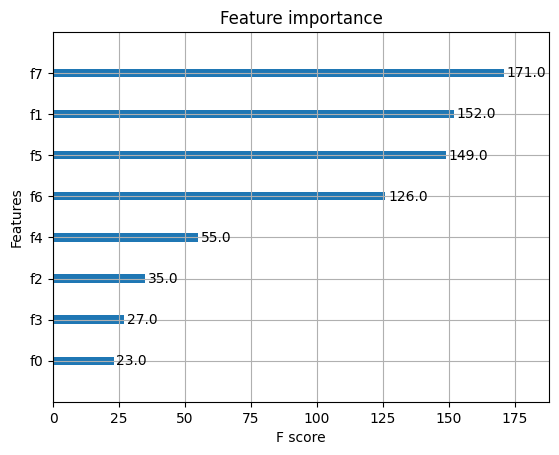

In [131]:
#Plotting feature importance of best XGBoost model
xgb.plot_importance(bst_optimal)

#Getting values for confusion matrix (plotted in R)
confusion_matrix(y_test, opt_pred)

In [ ]:

#print(hgb.results)

# Plot the hyperparameter tuning.
hgb.plot_params()

# Plot the summary of all evaluted models.
hgb.plot()

# Plot results on the k-fold cross-validation.
hgb.plot_cv()

# Plot results on the validation set.
hgb.plot_validation()

# Plot the best performing tree.
hgb.treeplot()

In [50]:
print(inspect.signature(hgb.xgboost))

(X, y, pos_label=None, method='xgb_clf', eval_metric=None, greater_is_better=None, params='default')
